**Poprzednie zadanie**

Usuwam kolumny: "PassengerId", "Name", "SibSp" oraz "Parch" (zamieniam na kolumnę "IsAlone"), "Ticket", "Cabin" (zamieniam na "knownCabins").
Kolumna target: "Survived".
Ostatecznie pozostaje przy zbiorze danych składających się z kolumn: "Pclass", "Sex", "Age", "Fare", "IsAlone", "knownCabins"; Z czego całość jest numerycznie przekonwertowana.

In [ ]:
def plot_correlation_matrix(df):
    """
    Plots a heatmap showing the correlation matrix for numeric columns in the DataFrame.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing numeric data.
    Returns:
        None. Displays the correlation heatmap.
    """
    # compute correlation matrix only for numeric columns
    corr = df.corr(numeric_only=True)

    # fmt=".2f" rounds the number to 0.01
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
base_path = Path('/content/drive/MyDrive/DataSets')

titanicData = pd.read_csv(base_path/ 'titanic.csv')
#Konwersja "Age"
titanicData["Age"] = titanicData["Age"].apply(lambda x: 1 if pd.notnull(x) and x < 1 else (round(x) if pd.notnull(x) else x))
age_values = titanicData["Age"].dropna().values
missing_mask = titanicData["Age"].isna()
titanicData.loc[missing_mask, "Age"] = np.random.choice(age_values, size=missing_mask.sum())
titanicData["Age"] = titanicData["Age"].astype(int)
#Konwersja "Sex"
titanicData["Sex"] = titanicData["Sex"].map({"male":1, "female":0})
#Utworzenie "isAlone"
titanicData["isAlone"] = ((titanicData["SibSp"] == 0) & (titanicData["Parch"] == 0)).astype(int)
#Konwersja "Fare"
titanicData["Fare"] = titanicData["Fare"].fillna(titanicData["Fare"].median())
#Utworzenie "knownCabins"
titanicData["Cabin"] = titanicData["Cabin"].fillna("Unknown")
titanicData["knownCabins"] = titanicData["Cabin"].apply(lambda x: "Unknown" if x == "Unknown" else "Known")
titanicData["knownCabins"] = titanicData["knownCabins"].map({"Known":1, "Unknown":0})
#Konwersja "Embarked"
titanicData["Embarked"] = titanicData["Embarked"].map({"S":0, "C":1, "Q":2})

finalTitanicData = titanicData.drop(["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"], axis=1)

Mounted at /content/drive


Zgodnie z sugestią wykreślam heatmap-ę danych ostatecznych, która przyda się w dalszym rozważaniu doboru modelu.

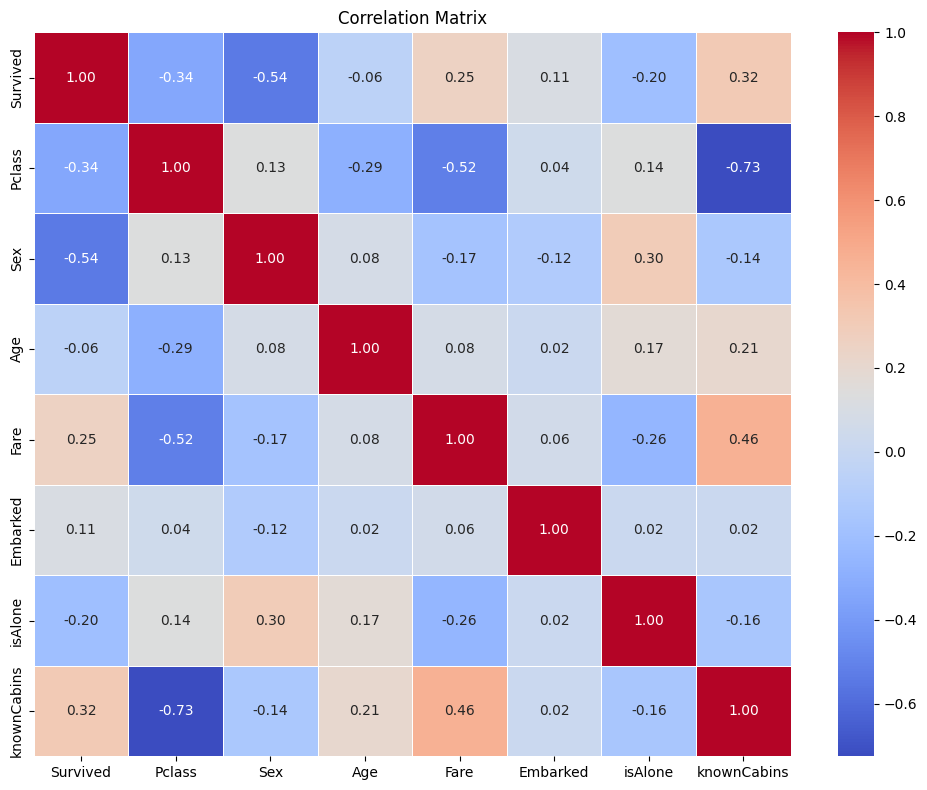

In [ ]:
plot_correlation_matrix(finalTitanicData)

**Zadanie 2:**

In [ ]:
#Ładuje ponownie dane żeby pracować "na nowo"
titanicData = pd.read_csv(base_path/ 'titanic.csv')

#Biblioteki na badanie utworzonego modelu
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

Konwertuje dane które nie powodują wycieki


In [ ]:
#Konwersja kolumny Sex binarnie
titanicData["Sex"] = titanicData["Sex"].map({"male":1, "female":0})

#Konwertuje błędne dane wpisane w kolumnę Age, np. 0.42 -> 1
titanicData["Age"] = titanicData["Age"].apply(lambda x: 1 if pd.notnull(x) and x < 1 else (round(x) if pd.notnull(x) else x))

#Utworzenie nowej kolumny sprawdzającej czy dana osoba podróżowała bez rodziny
titanicData["isAlone"] = ((titanicData["SibSp"] + titanicData["Parch"]) == 0).astype(int)

#Utworzenie nowej kolumny sprawdzającej czy znana jest kabina pasażera
titanicData["Cabin"] = titanicData["Cabin"].fillna("Unknown")
titanicData["knownCabins"] = titanicData["Cabin"].apply(lambda x: "Unknown" if x == "Unknown" else "Known")
titanicData["knownCabins"] = titanicData["knownCabins"].map({"Known":1, "Unknown":0})

#Mapowanie kolumny Embarked na tryb wyliczeniowy
titanicData["Embarked"] = titanicData["Embarked"].map({"S":0, "C":1, "Q":2})

Usuwam zbędne kolumny danych

In [ ]:
finalTitanicData = titanicData.drop(["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch"], axis=1)
X = finalTitanicData.drop("Survived", axis=1)
y = finalTitanicData["Survived"] # <-target

Dzielę dane na: 20% test; 80% train

In [ ]:
def random_impute_from_train(series, train_values):

    """
    Uzupełnienie brakujących wartości w kolumnie (series) danych na podstawie wartości z zestawu treningowego (trainValues).

    series :
        Kolumna z brakującymi wartościami do uzupełnienia
    trainValues :
        Tablica wartości ze zbioru treningowego (bez NaN), z której będą losowane dane
        do uzupełnienia braków.

    """
    series = series.copy()
    missing_mask = series.isna()
    series.loc[missing_mask] = np.random.choice(train_values, size=missing_mask.sum())
    return series


In [ ]:

# Test 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Konwersja Age
ageTrainValue = X_train["Age"].dropna().values
X_train.loc[:, "Age"] = random_impute_from_train(X_train["Age"], ageTrainValue)
X_test.loc[:, "Age"]  = random_impute_from_train(X_test["Age"], ageTrainValue)

# Konwersja Fare
fareMedian = X_train["Fare"].median()
X_train.loc[:, "Fare"] = X_train["Fare"].fillna(fareMedian)
X_test.loc[:, "Fare"]  = X_test["Fare"].fillna(fareMedian)

# Konwersja Embarked
embarkedMode = X_train["Embarked"].mode()[0]
X_train.loc[:, "Embarked"] = X_train["Embarked"].fillna(embarkedMode)
X_test.loc[:, "Embarked"]  = X_test["Embarked"].fillna(embarkedMode)



Dane są najpierw dzielone a dopiero później wartości NaN są zamieniane na odpowiedniki poprzedniego działania na danych, żeby nie spowodować ich wycieku.

**Trenowanie Modelu**

Sprawdzam parametry jakie posiada Dummy do dalszej analizy własnych modeli

In [ ]:
#Sprawdzenie poprzez Dummy
model = DummyClassifier(strategy = 'uniform')
model.fit(X_train, y_train) # uczenie

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))
confusion_matrix(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.57      0.51      0.54       439
           1       0.33      0.39      0.36       273

    accuracy                           0.46       712
   macro avg       0.45      0.45      0.45       712
weighted avg       0.48      0.46      0.47       712



array([[222, 217],
       [166, 107]])

Przed doborem modelu zdecydowałem że zwizualizuje "wagę" każdej z mojej cechy, do tego używam datę przez którą wyświetlałem moją heatmap-ę.

/tmp/ipython-input-2382658764.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


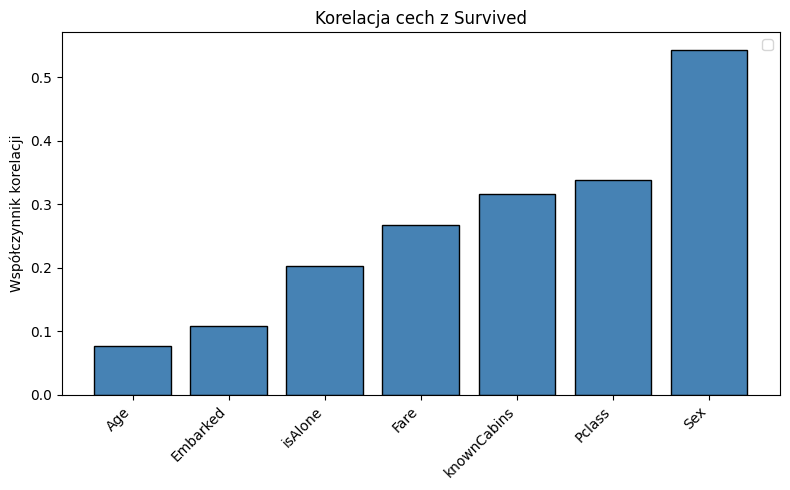

In [ ]:
correlations = finalTitanicData.corr(numeric_only=True)["Survived"].drop("Survived")
#Biorę wartości bezwzględne ponieważ łatwiej z tego wnioskować
correlations_abs = correlations.abs().sort_values(ascending=True)


plt.figure(figsize=(8, 5))
bars = plt.bar(correlations_abs.index, correlations_abs.values, color="steelblue", edgecolor="black")

plt.title("Korelacja cech z Survived")
plt.ylabel("Współczynnik korelacji")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


Zauważyć można następujące:

*   Charakterystyka cech po ich posortowaniu w skali rosnącej ma charakter w miarę "liniowy"
*   Najważniejszą cechą okazała się być kolumna "Sex"

W związku z tym stwierdziłem na zastosowanie modeli **Regresji logistycznej** (przyjmuje ona parametry 0 oraz 1 co dobrze odpowiada naszemu problemowi, dane u mnie są numeryczne a zatem też to jest dla tego modelu na korzyść, dodatkowo wykres cech ma charakter w miarę liniowy co jest tylko na plus) oraz **Drzewa decyzyjnego** (jest prosty oraz odporny na skalowanie danych, co wydawało mi się godne do sprawdzenia)

In [ ]:
#DecisionTree
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))
confusion_matrix(y_train, y_pred)

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       439
           1       0.88      0.66      0.75       273

    accuracy                           0.83       712
   macro avg       0.85      0.80      0.81       712
weighted avg       0.84      0.83      0.83       712



array([[414,  25],
       [ 94, 179]])

In [ ]:
#Regresja Logistyczna
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       439
           1       0.74      0.74      0.74       273

    accuracy                           0.80       712
   macro avg       0.79      0.79      0.79       712
weighted avg       0.80      0.80      0.80       712

[[368  71]
 [ 72 201]]


Oba modele są lepsze od Dummy o rozsądną ilość poprawnych odpowiedzi, dodatkowo:
*   Drzewo decyzyjne posiada metryki sięgające nawet 90% prócz recall "1"
*   Regresja logistyczna posiada w większości wszystko na podobnym poziomie (70 - 80%).



**Hiperparametry**

Dla DecisionTree postanowiłem sprawdzić hiperparametr max_depth, ponieważ on w największym przypadku powoduje "overfitting"

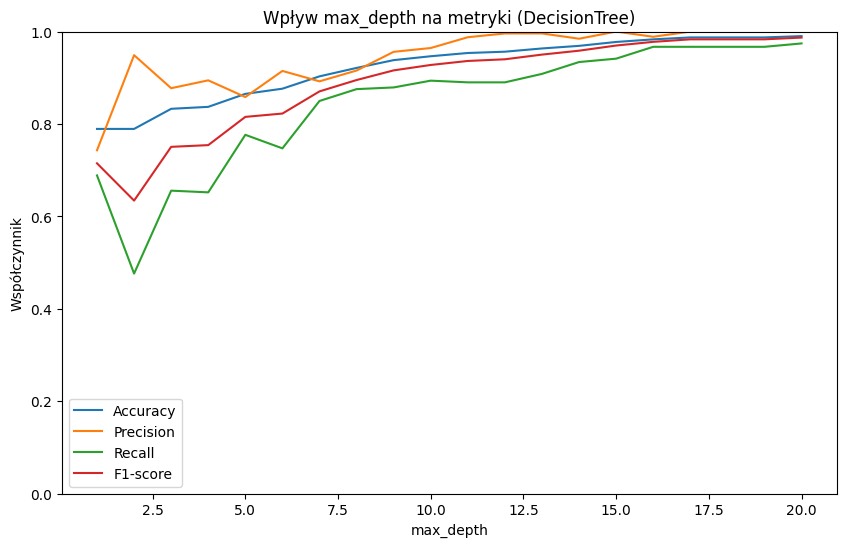

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

max_depths = range(1, 21)
results = []

for d in max_depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)

    results.append({
        "max_depth": d,
        "accuracy": accuracy_score(y_train, y_pred),
        "precision": precision_score(y_train, y_pred),
        "recall": recall_score(y_train, y_pred),
        "f1": f1_score(y_train, y_pred)
    })

df = pd.DataFrame(results)

plt.figure(figsize=(10,6))
plt.plot(df["max_depth"], df["accuracy"], label="Accuracy")
plt.plot(df["max_depth"], df["precision"], label="Precision")
plt.plot(df["max_depth"], df["recall"], label="Recall")
plt.plot(df["max_depth"], df["f1"], label="F1-score")
plt.xlabel("max_depth")
plt.ylabel("Współczynnik")
plt.title("Wpływ max_depth na metryki (DecisionTree)")
plt.legend()
plt.ylim(0,1)
plt.show()

Widoczne jest że przy wartościach już ok. 10-12 model zaczyna się stabilizować i osiąga niemal że 100% w każdej metryce, ale raczej to oznacza że model "zapamiętuje" wszystkie wartości na pamięć i właściwie dochodzi już tu do "overfitting-u".

Dla Regresji logistycznej postanowiłem sprawdzić hiperparametr C, ponieważ on w największym przypadku powoduje "overfitting" jak i również "underfitting"

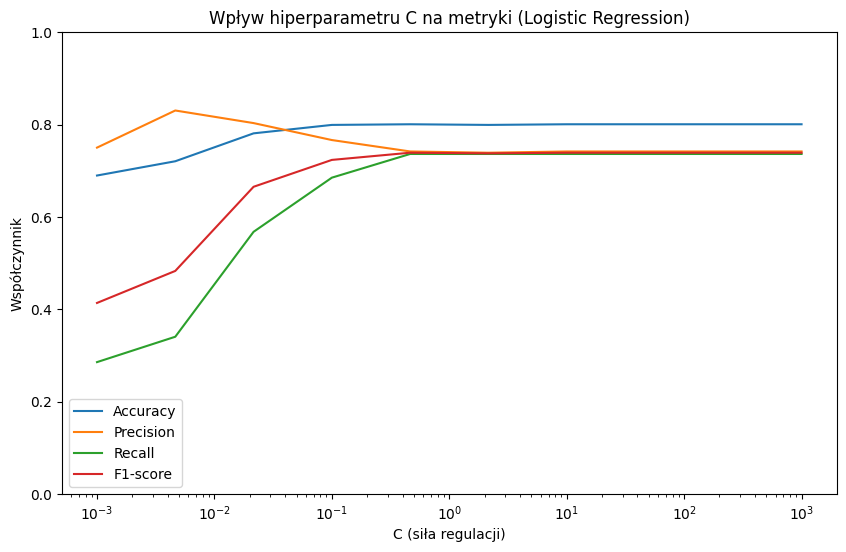

In [ ]:
Cs = np.logspace(-3, 3, 10)  # wartości od 10^-3 do 10^3
results = []

for c in Cs:
    model = LogisticRegression(C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)

    results.append({
        "C": c,
        "accuracy": accuracy_score(y_train, y_pred),
        "precision": precision_score(y_train, y_pred),
        "recall": recall_score(y_train, y_pred),
        "f1": f1_score(y_train, y_pred)
    })

df_log = pd.DataFrame(results)

plt.figure(figsize=(10,6))
plt.semilogx(df_log["C"], df_log["accuracy"], label="Accuracy")
plt.semilogx(df_log["C"], df_log["precision"], label="Precision")
plt.semilogx(df_log["C"], df_log["recall"], label="Recall")
plt.semilogx(df_log["C"], df_log["f1"], label="F1-score")
plt.xlabel("C (siła regulacji)")
plt.ylabel("Współczynnik")
plt.title("Wpływ hiperparametru C na metryki (Logistic Regression)")
plt.legend()
plt.ylim(0,1)
plt.show()

Widoczne jest że siła regulacji najprawdopodobniej będzie się mieściła gdzieś około wartości 10^-1 do 10^0, w innych przypadkach (np. poniżej zakresu)  może wystąpić sytuacja underfittingu bądź overfittingu (w przypadku regulacji powyżej zakresu)

**Wnioski**


*   Widoczne jest że utworzenie modelu faktycznie zależy od naprawdę wielu parametrów, poczynając chociażby z tego że nieodpowiednie przygotowanie danych może skutkować błędnym działaniem modelu.
*    Podczas doboru modelu warto rozpatrywać kilka ich rodzajów szczególnie wydaję się być dobre wizualizacja to w jaki sposób dany model się uczy oraz jak jego metryki zmieniają się na konkretne wartości

